# RBM in Tensorflow 2.0

## Import tensorflow

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

import tensorflow as tf
import tensorflow_probability as tfp

from image_utils import tile_raster_images

## Define cool functions alias

* $\sigma$ as `tf.sigmoid`
* $X \sim Bernouli(k;p) = p^{k}(1-p)^{1-k} \text{ for } k \in \{0,1\}$
* `mean` as `tf.math.reduce_mean`
* $\sum$ as `tf.reduce_sum`
* `softplus` as `tf.summarnn.softplus` ($\text{soft}_{+}$)


* Add attributes
  * `tensor.T` to transpose
  * `variable.T` to transpose
* Add methods
  * `tensor.reshape` as `tf.reshape(self, new_shape)`
  * `tensor.cast` to `tf.cast(self, new_dtype)`
  * `tensor.to_vector` to transfor the matrices as vectors

In [2]:
σ = tf.sigmoid
bernoulli_sample = lambda p, samples=(): tfp.distributions.Bernoulli(probs=p).sample(samples).cast(tf.float32)
mean = tf.math.reduce_mean
Σ = tf.reduce_sum
softplus = tf.nn.softplus

tf.Tensor.T = property(lambda self: tf.transpose(self))
tf.Variable.T = property(lambda self: tf.transpose(self))

tf.Tensor.reshape = lambda self, shape: tf.reshape(self, shape=shape)
tf.Tensor.cast = lambda self, dtype: tf.cast(self, dtype=dtype)
tf.Tensor.to_vector = lambda self: self.reshape(shape=(-1, 1))

## Define model parameters

**Note**: The vectors are _column vectors_

Hyperparameters:
* `hidden_size`: number of hidden units;
* `visible_size`: number of visible units. The element data input needs to be the same shape of the `visible_size`;
* `learning_rate`: ;
* `momentum`: ;
* `regualization`: ;
* `batch_size`: total of elements in a minibatch.

In [69]:
# Model hyperparameters
hidden_size = 100
visible_size = 28*28

# Learn hyperparameters
learning_rate = 0.1
momentum = 0
regularization = 0

batch_size = 100
epochs = 20

# Model parameters
W = tf.Variable(name='W', initial_value=0.01 * tf.random.normal([hidden_size, visible_size]), dtype=tf.float32)
b_h = tf.Variable(name='b_h', dtype=tf.float32, initial_value=tf.zeros([hidden_size, 1]))
b_v = tf.Variable(name='b_v', dtype=tf.float32, initial_value=tf.zeros([visible_size, 1]))

# Model parameters (learn)
ΔW = tf.Variable(name='dW', initial_value=tf.zeros([hidden_size, visible_size]), dtype=tf.float32)
Δb_v = tf.Variable(name='db_v', initial_value=tf.zeros([visible_size, 1]), dtype=tf.float32)
Δb_h = tf.Variable(name='db_h', initial_value=tf.zeros([hidden_size, 1]), dtype=tf.float32)

## Load dataset

In [49]:
import tensorflow_datasets as tfds

# Load dataset
dataset, info = tfds.load(name="mnist", split=tfds.Split.TRAIN, with_info=True)

In [53]:
# Format data
def format_image(data):
    image = data['image']

    image = image.reshape((visible_size, ))  # To vector format compatible with rbm visible label
    image = image / 255                       # normalization
    image = (image > 0.5).cast(tf.float32)    # binarization
    
    data['image'] = image
    return data

dataset = dataset.map(format_image)

In [54]:
# Build your input pipeline
dataset = dataset.repeat(epochs).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# Assert that the visible la
image_shape = info.features['image'].shape
assert visible_size == image_shape[0]*image_shape[1]

## Energy function

$$E(\boldsymbol{v}, \boldsymbol{h}) = - \boldsymbol{h}^T\boldsymbol{W}\boldsymbol{v} - \boldsymbol{v}^T\boldsymbol{b}^v - \boldsymbol{h}^T\boldsymbol{b}^h$$

In [8]:
def E(v, h):
    return - (h.T @ W @ v) - (v.T @ b_v) - (h.T @ b_h)

## Free energy function

$$F(\boldsymbol{v}) = - \boldsymbol{v}^T\boldsymbol{b}^v - \sum_{i=1}^{K} soft_{+}(\boldsymbol{W}_{i\cdot} \boldsymbol{v} + b_i^h)$$

In [9]:
def F(v):
    return -(v.T @ b_v) - Σ(softplus(W @ v + b_h), axis=0).to_vector()

## Conditional probabilities

* $P(h_i = 1|\boldsymbol{v}) = \sigma(\boldsymbol{W}_{i \cdot} \boldsymbol{v} + b^h_i)$
* $P(v_j=1|\boldsymbol{h}) = \sigma(\boldsymbol{h}^T \boldsymbol{W}_{\cdot j} + b^v_j)$

In [10]:
def P_h_given_v(v):
    return σ(W @ v + b_h)

def P_v_given_h(h):
    return σ(h.T @ W + b_v.T).T

## Sampling

* $\boldsymbol{p}_h \sim P(h_i = 1|\boldsymbol{v})$
* $\boldsymbol{p}_v \sim P(v_j=1|\boldsymbol{h})$

In [11]:
def gibbs_step(v0):
    P_h0 = P_h_given_v(v0)
    h0 = bernoulli_sample(p=P_h0)
    
    P_v1 = P_v_given_h(h0)
    v1 = bernoulli_sample(p=P_v1)

    return v1

## Learning

In [83]:
η = learning_rate
α = momentum
λ = regularization


for i, features in enumerate(dataset):
    image, label = features["image"], features["label"]

    v0 = image.T

    with tf.name_scope('gibbs_chain'):
        P_h0_given_v0 = P_h_given_v(v0)
        h0 = bernoulli_sample(p=P_h0_given_v0)

        P_v1_given_h0 = P_v_given_h(h0)
        v1 = bernoulli_sample(p=P_v1_given_h0)

        P_h1_given_v1 = P_h_given_v(v1)
        h1 = bernoulli_sample(p=P_h1_given_v1)

    with tf.name_scope('delta_W'):
        ΔW = η * (P_h0_given_v0 @ v0.T - P_h1_given_v1 @ v1.T) - λ*W + α*ΔW

    with tf.name_scope('delta_v_b'):
        Δb_v = η * mean(v0 - v1, axis=1).to_vector() + α*Δb_v

    with tf.name_scope('delta_h_b'):
        Δb_h = η * mean(P_h0_given_v0 - P_h1_given_v1, axis=1).to_vector() + α*Δb_h


    W = W + ΔW
    b_v = b_v + Δb_v
    b_h = b_h + Δb_h
    
    if i%(500) == 0:
        with tf.name_scope('summaries'):
            print('Step', i, mean(F(v0)))
            tf.summary.scalar('FreeEnergy', mean(F(v0)))


Step 0 tf.Tensor(52.076393, shape=(), dtype=float32)
Step 200 tf.Tensor(36.787724, shape=(), dtype=float32)
Step 400 tf.Tensor(31.767939, shape=(), dtype=float32)
Step 600 tf.Tensor(21.679766, shape=(), dtype=float32)
Step 800 tf.Tensor(25.0812, shape=(), dtype=float32)
Step 1000 tf.Tensor(19.846827, shape=(), dtype=float32)
Step 1200 tf.Tensor(20.270914, shape=(), dtype=float32)
Step 1400 tf.Tensor(14.834299, shape=(), dtype=float32)
Step 1600 tf.Tensor(15.3133545, shape=(), dtype=float32)
Step 1800 tf.Tensor(10.395665, shape=(), dtype=float32)
Step 2000 tf.Tensor(2.5684137, shape=(), dtype=float32)
Step 2200 tf.Tensor(3.439096, shape=(), dtype=float32)
Step 2400 tf.Tensor(12.875156, shape=(), dtype=float32)
Step 2600 tf.Tensor(11.435757, shape=(), dtype=float32)
Step 2800 tf.Tensor(6.5250306, shape=(), dtype=float32)
Step 3000 tf.Tensor(19.589022, shape=(), dtype=float32)
Step 3200 tf.Tensor(7.26309, shape=(), dtype=float32)
Step 3400 tf.Tensor(-2.5835938, shape=(), dtype=float32)
St

KeyboardInterrupt: 

In [81]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## Plots

### Weights

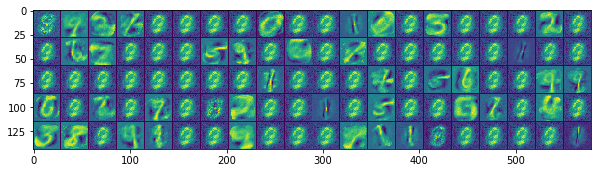

In [84]:
plt.imshow(tile_raster_images(
    X=W.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

### Input

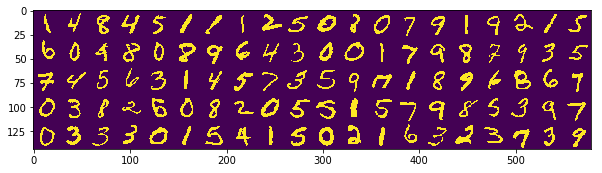

In [85]:
plt.imshow(tile_raster_images(
    X=image.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

### Probability

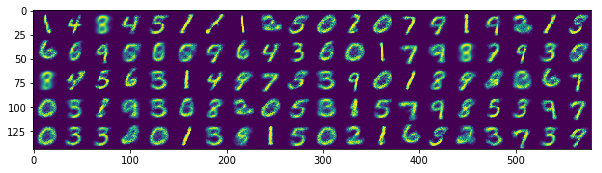

In [86]:
image_probability = P_v_given_h(P_h_given_v(image.T))

plt.imshow(tile_raster_images(
    X=image_probability.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

### Sampled

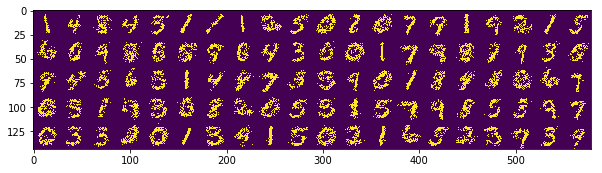

In [87]:
image_reconstructed = gibbs_step(image.T)

plt.imshow(tile_raster_images(
    X=image_reconstructed.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))